In [6]:
import numpy as np

In [7]:
class Graph(object):

    def __init__(self):

        self._rvs = {} #a dictionary of rv
        self._factors = [] #a list of factors
        self._connected_comp = []

    def rv(self, name, n_opts):
        '''
        Args:
            name (str)
            n_opts (int) how many values it can take
        returns:
            RV
        '''
        rv = RV(name, n_opts)
        self.add_rv(rv)
        return rv

    def has_rv(self, rv_s):
        '''
        args:
            potential rv
        returns:
            bool
        '''
        return rv_s in self._rvs

    def add_rv(self, rv):
        self._rvs[rv.name]=rv
        self._connected_comp += [[rv.name]]

    def factor(self, rvs, name="", potential=None): #oss:rvs must be already part of the graph: the graph must be done in order, 1st rv, then factors
        for i in range(len(rvs)):
            assert isinstance(rvs[i],(str,RV))
            if isinstance(rvs[i], str):
                rvs[i] = self._rvs[rvs[i]] #if I give a list of name, it looks in the dictionary and change each name with the RV
            assert type(rvs[i]) is RV

        f = Factor(rvs, name, potential)
        self.add_factor(f)

        new_connected=[name]

        for rv in rvs:
            rv.attach(f) #I attach to each rv the factor
            i=0
            while rv.name not in self._connected_comp[i]:
                i+=1
            new_connected += self._connected_comp[i]
            self._connected_comp.remove(self._connected_comp[i])

        self._connected_comp += [new_connected]

        return f

    def add_factor(self, factor):
        self._factors += [factor]

    def find_connected(self, element):
        if not isinstance(element, str):
            el=element.name
        else:
            el=element
        i=0
        while el not in self._connected_comp[i] and i<=len(self._connected_comp):
            i+=1
        if i>len(self._connected_comp):
            return None
        return self._connected_comp[i], i

    def kruskal(self, weight):
        '''
        Given the weights between nodes, this alghoritms adds the links
        (by inserting factors) with smaller weights, checking that it is
        creating cycles. It stops when the tree is built.

        Notice: the function takes the connected components already present in
        the graph. This means that the final result is not a tree if you did
        not start from a forest.

        Args:
            weight is a square matrix
        '''
        weight=np.triu(weight, 1) #we cancel elements in the diagonal and below it
        N=weight.shape[0]
        sort=np.argsort(weight, axis=None)
        for order in sort:
            if len(self._connected_comp)==1:
                break
            #I check that nodes i=order//N, j=order%N are in two different connected components
            if self.find_connected(str(order//N))!=self.find_connected(str(order%N)):
                self.factor([self._rvs[str(order//N)],self._rvs[str(order%N)]], name=f"J_{order//N},{order%N}", potential=0.3)
                
    #def zero_connected_components(self):
    #    self._connected_comp += [[list(self._rvs.keys())[i]] for i in range(len(self._rvs.keys()))] #+ [[self._factors[i]] for i in range(len(self._factors))]

class RV(object):
    def __init__(self, name, n_opts):

        self.name = name
        self.n_opts=n_opts
        self._factors=[] #each random variable has a list of its neighbouring factors
        self._incoming_msg = None
        self._beliefs = None

    def n_edges(self):
        return len(self._factors)

    def attach(self, factor): #I create a function to connect a RV to a factor
            for f in self._factors:
                assert f!=factor, "Can't re-add factor %r to rv %r" % (factor,self)
            self._factors += [factor]

    def magn(self):
        return -self._beliefs[0]+self._beliefs[1]

class Factor(object):
    def __init__(self, rvs, name="", potential=None):
        self.name = name
        self._rvs = [] #as above, each factor has a list of neighbouring RV
        self.potential = potential
        self._incoming_msg = None
        self._beliefs = None
        for rv in rvs:
            self.attach(rv)

    def n_edges(self):
        return len(self._rvs)

    def attach(self, rv):
            for rvs in self._rvs:
                assert rvs!=rv, "Can't re-add factor %r to rv %r" % (rvs,self)
            self._rvs += [rv]

    def corr(self):
        return self._beliefs[0]+self._beliefs[3]-self._beliefs[1]-self._beliefs[2]



In [45]:
import copy

class messages:

    def __init__(self, ising_model, T):
        '''
        ising model is the Graph structure
        T is the temperature
        '''
        self.graph = copy.deepcopy(ising_model)
        self.beta = 1/T
        self.configurations = []


        # initialize to 0.1 the msgs to down spins
        # and to 1 the msgs to up spins
        for i in self.graph._rvs.values():
            l = len(i._factors)
            i._incoming_msg = [np.ones(l)*0.1, np.ones(l)] #we have as many messages to a rv as the factors connected to it
        for i in self.graph._factors:
            l = len(i._rvs)
            i._incoming_msg = [[0.1,1]]*l

    def psi_ij(self, link, s1, s2): #Hamiltonian is given as H=- (sum J_ij s_is_j) - sum h_i s_i
        J = link.potential
        return np.exp(self.beta*s1*s2*J)

    def psi_i(self, field, s):
        h = field.potential
        return np.exp(self.beta*s*h)

    def _variable_to_factor_messages(self, variable, factor):

        not_factor=[i!=factor for i in variable._factors]
        # Take the product over all incoming factors into this variable except the variable

        mex0=1
        mex1=1
        for i in range(len(not_factor)):
            if not_factor[i]:
                mex0*=variable._incoming_msg[0][i]
                mex1*=variable._incoming_msg[1][i]

        to_change_index=np.where(np.array([i==variable for i in factor._rvs])==True)[0][0]
        #factor._incoming_msg[to_change_index][1]=mex0
        #factor._incoming_msg[to_change_index][0]=mex1
        return [mex0, mex1], to_change_index

    def _factor_to_variable_messages(self, factor, variable):
        # Compute the product
        not_variable=[i!=variable for i in factor._rvs]

        number_neigh = factor.n_edges()
        to_change_index=np.where(np.array([i==factor for i in variable._factors])==True)[0][0]
        output=[]
        #This is specific for the Ising model: only two cases are possible: the factor is a field or a link
        for s in [-1,1]: #value of variable we are passing message to
            if number_neigh == 1:
                mex0=self.psi_i(factor, s)
            if number_neigh == 2:
                mex0=self.psi_ij(factor,s,-1)*factor._incoming_msg[np.where(np.array(not_variable)==True)[0][0]][0]
                mex0+=self.psi_ij(factor,s,+1)*factor._incoming_msg[np.where(np.array(not_variable)==True)[0][0]][1]
                #2*np.cosh(self.beta*s*factor.potential)*factor._incoming_msg[np.where(np.array(not_variable)==True)[0][0]][int((s+1)/2)]
            #variable._incoming_msg[s][to_change_index]=mex0
            output.append(mex0)
        return output, to_change_index

    def one_node_marginal(self, variable):
        b=[]
        for i in variable._incoming_msg:
            b.append(np.prod(i))
        b=np.array(b)/np.sum(np.array(b))

        variable._beliefs=b


    def link_marginal(self, factor):
        #we create a four elements array with [-1,-1],[-1,1],[1,-1],[1,1]
        bel=[0,0,0,0]
        bel[0]=self.psi_ij(factor,-1,-1)*factor._incoming_msg[0][0]*factor._incoming_msg[1][0]
        bel[1]=self.psi_ij(factor,-1,1)*factor._incoming_msg[0][0]*factor._incoming_msg[1][1]
        bel[2]=self.psi_ij(factor,1,-1)*factor._incoming_msg[0][1]*factor._incoming_msg[1][0]
        bel[3]=self.psi_ij(factor,1,1)*factor._incoming_msg[0][1]*factor._incoming_msg[1][1]
        bel=np.array(bel)/np.sum(np.array(bel))

        factor._beliefs=bel


    def update_msg(self):
        graphc=copy.deepcopy(self.graph)

        new_msg_list=[]
        #iterate over all graph
        for node in list(self.graph._rvs.values()):
            #iterate over nn of the current node
            for factor in node._factors:
                #iterate over states of the node
                msg, index = self._factor_to_variable_messages(factor, node)
                for s in [0,1]:
                        #update must be done in parallel
                        graphc._rvs[node.name]._incoming_msg[s][index]=msg[s]
                        new_msg_list.append(msg[s])
        for node in graphc._factors:
            #iterate over nn of the current node
            for variable in node._rvs:
                #iterate over states of the node
                msg, index = self._variable_to_factor_messages(variable, node)

                #update must be done in parallel
                for s in [0,1]:
                    #factor._incoming_msg[to_change_index][1]=mex0
                    #factor._incoming_msg[to_change_index][0]=mex1
                    node._incoming_msg[index][s]=msg[s]
                    new_msg_list.append(msg[s])

        # normalize the messages
        if np.sqrt(np.max(new_msg_list))>10**3:
              norm=np.sqrt(np.max(new_msg_list))
        else:
              norm=10**3
        error=[]

        for node in list(self.graph._rvs.values()):
            for s in [0,1]:
                error.append(self.graph._rvs[node.name]._incoming_msg[s]-graphc._rvs[node.name]._incoming_msg[s]/norm)
                self.graph._rvs[node.name]._incoming_msg[s]=graphc._rvs[node.name]._incoming_msg[s]/norm
        error2=[]
        i=0
        for i in range(len(graphc._factors)):
            error2.append(np.array(self.graph._factors[i]._incoming_msg)-np.array(graphc._factors[i]._incoming_msg)/norm)
            self.graph._factors[i]._incoming_msg=np.array(graphc._factors[i]._incoming_msg)/norm
        error=np.concatenate(error)
        error2=np.concatenate(error2).reshape(-1)
        error=np.concatenate([error,error2])

        return error
    
    
    def recursive_factor_sample(self, factor, variable, spin):
        if factor.name[0]=='J':
            index=1
            for i in factor._rvs:
                if i!=variable:
                    position2=int(i.name)
                    variablebis=i
                    break
                else:
                    index=0 #index is one if the variable I come from is the second appearing in the list, 0 if it is the first 
            
            whole_bel=factor._beliefs
            if index==0 and spin==-1:
                norm=whole_bel[0]+whole_bel[1]
                conditional_marginal=[whole_bel[0]/norm,whole_bel[1]/norm]
            if index==0 and spin==+1:
                norm=whole_bel[2]+whole_bel[3]
                conditional_marginal=[whole_bel[2]/norm,whole_bel[3]/norm]
            if index==1 and spin==-1:
                norm=whole_bel[0]+whole_bel[2]
                conditional_marginal=[whole_bel[0]/norm,whole_bel[2]/norm]
            if index==1 and spin==+1:
                norm=whole_bel[1]+whole_bel[3]
                conditional_marginal=[whole_bel[1]/norm,whole_bel[3]/norm]
            
            spinbis=np.random.choice([-1,1], p=conditional_marginal)
            self.configuration[position2]=spinbis
            for factorbis in variablebis._factors:
                if factorbis!= factor:
                    self.recursive_factor_sample(factorbis, variablebis, spinbis)
                


    def sample_from_tree(self):
        self.configuration=np.zeros([len(self.graph._rvs.keys())])
        
        #I take the first variable and use it
        variable=list(self.graph._rvs.values())[0]
        position=int(variable.name)
        spin=np.random.choice([-1,1], p=variable._beliefs)
        self.configuration[position]=spin
        for factor in variable._factors:
            self.recursive_factor_sample(factor, variable, spin)
    


In [46]:
def belief_step(Belief_prop_graph, max_iter=1920):
    A=np.array(1e7)
    itera=1
    print('First iteration')
    while ((not np.allclose(A**2,0)) and itera<max_iter):
        itera+=1
        A=Belief_prop_graph.update_msg()
        print('Iteration ', itera, 'rmse:', np.sqrt(np.sum(A**2)))

In [47]:
class adaptive_grad():
    def __init__(self, theta: np.array, objective: np.array, l=0, eta=0, gamma=1e-2, eps=1e-10, sum_state=0, beta=0.5):
        self.theta=theta #all the parameters hi, Jij
        self.objective=objective #the array of the value of the magnetisations and covariances to reach

        self.gamma=gamma #learning rate
        self.l=l #for an L2 like penalty
        self.eta=eta #learning rate decay
        self.eps=eps #regularisation
        self.beta=beta #normalize sum state

        self.sum_state=sum_state #for the initialization of the algo

    def new_theta(self, averages, t):
        '''
        It takes the computed averages and used them to compute the gradient
        '''
        gt=-self.objective+averages  #This is -grad: we are using the hamiltonian with opposite signs!!!!
        gamma2=self.gamma/(1+(t-1)*self.eta)
        if self.l!=0:
            gt=gt+self.l*self.theta
        self.sum_state=self.beta*self.sum_state+(1-self.beta)*gt**2
        self.theta=self.theta-gamma2*gt/(np.sqrt(self.sum_state)+self.eps)
        return self.theta, np.sqrt(np.sum(gt**2))


# Chow Liu

In [48]:
X_test=np.array([[1,1,1,-1,1],[1,-1,1,-1,1],[1,1,1,-1,1],[-1,-1,1,1,1],[-1,1,-1,1,-1],[-1,1,1,-1,-1]])
m=np.sum(X_test, axis=0)/X_test.shape[0]
Cor=X_test.T@X_test/X_test.shape[0]

MI=np.zeros([5,5])
for i in range(5):
    for j in range(i+1,5):
        p_i = [(1-m[i])/2,(1+m[i])/2]
        p_j = [(1-m[j])/2,(1+m[j])/2]
        p_ij = 0 ## --, -+, +-, ++
        for s1 in [-1,1]:
            for s2 in [-1,1]:
                p_ij=(1/4*(Cor[i,j]*s1*s2+m[i]*s1+m[j]*s2+1))
                #print('Spins:',s1,s2,'\tPos:',i+1,j+1, '\t', p_i[int((s1+1)/2)], p_j[int((s1+1)/2)], p_ij)
                if p_ij!=0:
                    MI[i,j]+=p_ij*np.log2(p_ij/p_i[int((s1+1)/2)]/p_j[int((s2+1)/2)])
print(MI)

[[0.         0.         0.1908745  0.45914792 0.45914792]
 [0.         0.         0.10917034 0.04411042 0.25162917]
 [0.         0.         0.         0.31668909 0.31668909]
 [0.         0.         0.         0.         0.04411042]
 [0.         0.         0.         0.         0.        ]]


In [49]:
init_m = lambda mi : np.arctanh(mi) if mi!= -1 and np.arctanh(mi)>-5 and np.arctanh(mi)<5 else 5*mi/abs(mi)
T=Graph()
for i in range(5):
    T.rv(str(i),2)
    T.factor([str(i)], name=f'h_{i}', potential=init_m(m[i]))
T.kruskal(-MI)

# Check belief propagation

In [50]:
#Let's see what should happen for an hamiltonian such as:
##H=-J12 s1 s2 -h1s1 -h2s2
print("Let's see the probabilities for H=-J12 s1 s2 -h1s1 -h2s2")

J12=-2
h1=2
h2=1.5
h=[h1,h2]
T=2
print(f"With J12={J12}, h1={h1}, h2={h2} at temperature T={T}")
#ordered as --,-+,+-,++
order=['--','-+','+-','++']
p=np.array([np.exp(-1/T*(-J12+h1+h2)),np.exp(-1/T*(J12+h1-h2)),np.exp(-1/T*(J12-h1+h2)),np.exp(-1/T*(-J12-h1-h2))])  
p=p/np.sum(p)
for i in range(4):
    print(order[i],':\t',p[i])
p1p=p[1]+p[3]
p1m=p[0]+p[2]
p0p=p[3]+p[2]
p0m=1-p0p
m1=p1p-p1m
m0=p0p-p0m
print(r'p_1(+)',p[1]+p[3], r'p_1(-)',p[0]+p[2],'\n', r'p_0(+)', p[3]+p[2], r'p_0(-)', 1-p[3]-p[2])

Let's see the probabilities for H=-J12 s1 s2 -h1s1 -h2s2
With J12=-2, h1=2, h2=1.5 at temperature T=2
-- :	 0.008208222649468081
-+ :	 0.27181900281471044
+- :	 0.4481537717211111
++ :	 0.27181900281471044
p_1(+) 0.5436380056294209 p_1(-) 0.45636199437057917 
 p_0(+) 0.7199727745358215 p_0(-) 0.2800272254641784


In [51]:
#Let's see if we get the same results using our algorithm of belief propagation
Tree=Graph()
for i in range(2):
    Tree.rv(str(i),2)
    Tree.factor([str(i)], name=f'h_{i}', potential=h[i])
Tree.factor(['0','1'], name="J_12", potential=J12)
example=messages(Tree,T)
belief_step(example)

First iteration
Iteration  2 rmse: 2.83799865415817
Iteration  3 rmse: 0.005677141409752664
Iteration  4 rmse: 2.258853804108581e-06


In [52]:
example.link_marginal(example.graph._factors[-1])
print(example.graph._factors[-1]._beliefs)

example.one_node_marginal(example.graph._rvs['1'])
print(example.graph._rvs['1']._beliefs)

example.one_node_marginal(example.graph._rvs['0'])
variable=example.graph._rvs['0']
print(variable._beliefs)

[0.00820822 0.271819   0.44815377 0.271819  ]
[0.45636199 0.54363801]
[0.28002723 0.71997277]


# Final test

In [53]:
#Let's create the graph and compute the objective
Tree=Graph()
for i in range(2):
    Tree.rv(str(i),2)
    Tree.factor([str(i)], name=f'h_{i}', potential=h[i])
Tree.factor(['0','1'], name="J_1,2", potential=J12)

Belief_prop_graph = messages(Tree,T)

objective=np.array([p[0]+p[3]-p[1]-p[2],m0,m1])
objective

array([-0.43994555,  0.43994555,  0.08727601])

Let's test our algorithm.
First of all we check that if we start from the right solution, we reach it.

In [54]:
theta=np.zeros([2+1])

index=0
for factor in Belief_prop_graph.graph._factors:
      if factor.name[0]=='J':
        print(factor.name)
        lista=factor.name[2:].split(',')
        i=int(lista[0])
        j=int(lista[1])
        theta[index]=factor.potential
        index+=1

for rv in Belief_prop_graph.graph._rvs.values():
    i=int(rv.name[:2])
    print(rv.name)
    for factor in rv._factors:
        if factor.name[0]=='h':
            theta[index]=factor.potential
            break
    index+=1
print(theta)

J_1,2
0
1
[-2.   2.   1.5]


In [55]:
error=[1e5]
thr=2*9*1e-3
max_iter=1e4
iteration=1
averages=np.zeros([2+1])

#initialize grad
grad = adaptive_grad(theta, np.array(objective),eta=0.01, beta=0.5)

while error[-1]>thr and iteration<max_iter:
  print('\n Cycle:',iteration)
  belief_step(Belief_prop_graph)

  #compute marginals and averages
  index=0
  for factor in Belief_prop_graph.graph._factors:
    if factor.name[0]=='J':
      Belief_prop_graph.link_marginal(factor)
      averages[index]=factor.corr()
      index+=1
  for rv in Belief_prop_graph.graph._rvs.values():
    Belief_prop_graph.one_node_marginal(rv)
    averages[index]=rv.magn()
    index+=1

  #gradient step
  par, error0 = grad.new_theta(averages, iteration)
  error.append(error0)
  
  #update theta
  index=0
  for factor in Belief_prop_graph.graph._factors:
    if factor.name[0]=='J':
      factor.potential=par[index]
      print('Ichanged to', par[index], index)
      index+=1

  for rv in Belief_prop_graph.graph._rvs.values():
    for factor in rv._factors:
      if factor.name[0]=='h':
        factor.potential=par[index]
        print('Ichanged to', par[index], index)
        index+=1
        break

  iteration+=1
  print('Error was', error0,'\n----------------------')


 Cycle: 1
First iteration
Iteration  2 rmse: 2.83799865415817
Iteration  3 rmse: 0.005677141409752664
Iteration  4 rmse: 2.258853804108581e-06
Ichanged to -2.0 0
Ichanged to 2.000000016653326 1
Ichanged to 1.4999999888977784 2
Error was 2.0014830212433605e-16 
----------------------


In [56]:
for factor in Belief_prop_graph.graph._factors:
    print(factor.name,'\t', factor.potential)

h_0 	 2.000000016653326
h_1 	 1.4999999888977784
J_1,2 	 -2.0


Now let's see if we start from wrong initial conditions.

In [57]:
Tree=Graph()
for i in range(2):
    Tree.rv(str(i),2)
    Tree.factor([str(i)], name=f'h_{i}', potential=h[i]+np.random.uniform())
Tree.factor(['0','1'], name="J_1,2", potential=J12+np.random.uniform())

Belief_prop_graph = messages(Tree,T)

In [58]:
theta=np.zeros([2+1])

index=0
for factor in Belief_prop_graph.graph._factors:
      if factor.name[0]=='J':
        print(factor.name)
        lista=factor.name[2:].split(',')
        i=int(lista[0])
        j=int(lista[1])
        theta[index]=factor.potential
        index+=1

for rv in Belief_prop_graph.graph._rvs.values():
    i=int(rv.name[:2])
    print(rv.name)
    for factor in rv._factors:
        if factor.name[0]=='h':
            theta[index]=factor.potential
            break
    index+=1
print(theta)

J_1,2
0
1
[-1.31398213  2.75070199  1.67115479]


In [59]:
error=[1e5]
thr=1e-3
max_iter=1e4
iteration=1
averages=np.zeros([2+1])

#initialize grad
grad = adaptive_grad(theta, np.array(objective),eta=0.01, beta=0.5)

while error[-1]>thr and iteration<max_iter:
  print('\n Cycle:',iteration)
  belief_step(Belief_prop_graph)

  #compute marginals and averages
  index=0
  for factor in Belief_prop_graph.graph._factors:
    if factor.name[0]=='J':
      Belief_prop_graph.link_marginal(factor)
      averages[index]=factor.corr()
      index+=1
  for rv in Belief_prop_graph.graph._rvs.values():
    Belief_prop_graph.one_node_marginal(rv)
    averages[index]=rv.magn()
    index+=1

  #gradient step
  par, error0 = grad.new_theta(averages, iteration)
  error.append(error0)
  
  #update theta
  index=0
  for factor in Belief_prop_graph.graph._factors:
    if factor.name[0]=='J':
      factor.potential=par[index]
      print('Ichanged to', par[index], index)
      index+=1

  for rv in Belief_prop_graph.graph._rvs.values():
    for factor in rv._factors:
      if factor.name[0]=='h':
        factor.potential=par[index]
        print('Ichanged to', par[index], index)
        index+=1
        break

  iteration+=1
  print('Error was', error0,'\n----------------------')


 Cycle: 1
First iteration
Iteration  2 rmse: 2.8373780710441205
Iteration  3 rmse: 0.004515438183756873
Iteration  4 rmse: 4.427804423973248e-06
Ichanged to -1.3281242625872594 0
Ichanged to 2.736559858306487 1
Ichanged to 1.6570126585089744 2
Error was 0.5952938989457062 
----------------------

 Cycle: 2
First iteration
Iteration  2 rmse: 4.591080173469633e-05
Ichanged to -1.3394423952176329 0
Ichanged to 2.7251896511286873 1
Ichanged to 1.645842450484619 2
Error was 0.5780168982605864 
----------------------

 Cycle: 3
First iteration
Iteration  2 rmse: 3.651697360136667e-05
Ichanged to -1.3497671822261423 0
Ichanged to 2.7147756930640545 1
Ichanged to 1.6356951658900911 2
Error was 0.5652506137978877 
----------------------

 Cycle: 4
First iteration
Iteration  2 rmse: 3.320102834044213e-05
Ichanged to -1.3596163008762334 0
Ichanged to 2.704821439163566 1
Ichanged to 1.6260514764057181 2
Error was 0.5535606197362848 
----------------------

 Cycle: 5
First iteration
Iteration  2 r

Iteration  2 rmse: 1.862377012995753e-05
Ichanged to -1.7517279382432152 0
Ichanged to 2.3088646354971853 1
Ichanged to 1.489100833052483 2
Error was 0.2146414928930816 
----------------------

 Cycle: 56
First iteration
Iteration  2 rmse: 1.561751546678669e-05
Ichanged to -1.7580132038895193 0
Ichanged to 2.302567203382555 1
Ichanged to 1.496599294812187 2
Error was 0.20815082303495494 
----------------------

 Cycle: 57
First iteration
Iteration  2 rmse: 1.822918709619183e-05
Ichanged to -1.7643080278492775 0
Ichanged to 2.296283397704629 1
Ichanged to 1.4924577329792983 2
Error was 0.20560478158356255 
----------------------

 Cycle: 58
First iteration
Iteration  2 rmse: 1.5457742633019127e-05
Ichanged to -1.7705065610391573 0
Ichanged to 2.290072225077688 1
Ichanged to 1.4998884622467457 2
Error was 0.19914341770124266 
----------------------

 Cycle: 59
First iteration
Iteration  2 rmse: 1.7957612155217593e-05
Ichanged to -1.776717175621661 0
Ichanged to 2.28387212833456 1
Ichange

Iteration  2 rmse: 1.0063952947797294e-05
Ichanged to -2.0233132364496775 0
Ichanged to 2.03644465054613 1
Ichanged to 1.5281660987341434 2
Error was 0.008759190484121222 
----------------------

 Cycle: 108
First iteration
Iteration  2 rmse: 1.0646798713609023e-05
Ichanged to -2.025383541337325 0
Ichanged to 2.0339129470722126 1
Ichanged to 1.5328060198300344 2
Error was 0.0044261845841001264 
----------------------

 Cycle: 109
First iteration
Iteration  2 rmse: 8.775703833387561e-06
Ichanged to -2.0279918031790043 0
Ichanged to 2.030840734021005 1
Ichanged to 1.5276001999865867 2
Error was 0.00438110802810536 
----------------------

 Cycle: 110
First iteration
Iteration  2 rmse: 1.010748880890332e-05
Ichanged to -2.0274787503312943 0
Ichanged to 2.0300223251596083 1
Ichanged to 1.531898294348779 2
Error was 0.0013371124138858825 
----------------------

 Cycle: 111
First iteration
Iteration  2 rmse: 6.873356786369743e-06
Ichanged to -2.0291155341343345 0
Ichanged to 2.0273328833649

Iteration  2 rmse: 8.63497031151596e-06
Ichanged to -2.006364401725389 0
Ichanged to 2.002826068506354 1
Ichanged to 1.5028783976784872 2
Error was 0.0027296880747524816 
----------------------

 Cycle: 178
First iteration
Iteration  2 rmse: 9.24827051789978e-06
Ichanged to -2.0026507253664136 0
Ichanged to 2.006292348742041 1
Ichanged to 1.506343111100302 2
Error was 0.002596868985753957 
----------------------

 Cycle: 179
First iteration
Iteration  2 rmse: 8.588463380488268e-06
Ichanged to -2.0061094993319184 0
Ichanged to 2.002593200158011 1
Ichanged to 1.5026427137473954 2
Error was 0.0027073683483615236 
----------------------

 Cycle: 180
First iteration
Iteration  2 rmse: 9.16768968659278e-06
Ichanged to -2.002427471597488 0
Ichanged to 2.006041032511547 1
Ichanged to 1.5060890688905175 2
Error was 0.0025812188057465937 
----------------------

 Cycle: 181
First iteration
Iteration  2 rmse: 8.541853194529512e-06
Ichanged to -2.0058676741746195 0
Ichanged to 2.002373269087059 1


Iteration  2 rmse: 6.025019214564566e-06
Ichanged to -1.998920131837061 0
Ichanged to 2.0013457895058604 1
Ichanged to 1.5013467626173358 2
Error was 0.001791318257272919 
----------------------

 Cycle: 313
First iteration
Iteration  2 rmse: 5.994189509832264e-06
Ichanged to -2.001338286846554 0
Ichanged to 1.998921407996068 1
Ichanged to 1.498922346581865 2
Error was 0.0017900830492822068 
----------------------

 Cycle: 314
First iteration
Iteration  2 rmse: 5.9954377681449e-06
Ichanged to -1.9989198695922812 0
Ichanged to 2.0013337543131073 1
Ichanged to 1.501334661037137 2
Error was 0.0017827249306718636 
----------------------

 Cycle: 315
First iteration
Iteration  2 rmse: 5.965595933497563e-06
Ichanged to -2.0013265183746722 0
Ichanged to 1.9989212038790278 1
Ichanged to 1.4989220779425325 2
Error was 0.0017813691311542438 
----------------------

 Cycle: 316
First iteration
Iteration  2 rmse: 5.966160946926402e-06
Ichanged to -1.9989198697017312 0
Ichanged to 2.001322097849791

Iteration  2 rmse: 4.1009460799964775e-06
Ichanged to -1.9991833180446348 0
Ichanged to 2.000837582869555 1
Ichanged to 1.5008374333248775 2
Error was 0.0012222998178522543 
----------------------

 Cycle: 505
First iteration
Iteration  2 rmse: 4.09390035669055e-06
Ichanged to -2.0008361442294236 0
Ichanged to 1.9991846573903407 1
Ichanged to 1.4991845078289716 2
Error was 0.0012203260129605956 
----------------------

 Cycle: 506
First iteration
Iteration  2 rmse: 4.087386657195803e-06
Ichanged to -1.9991859456920427 0
Ichanged to 2.0008347550359358 1
Ichanged to 1.5008346061112563 2
Error was 0.0012182617957686187 
----------------------

 Cycle: 507
First iteration
Iteration  2 rmse: 4.0803918223659844e-06
Ichanged to -2.0008333271082006 0
Ichanged to 1.9991872766793155 1
Ichanged to 1.4991871277456923 2
Error was 0.0012163001539287658 
----------------------

 Cycle: 508
First iteration
Iteration  2 rmse: 4.073916697479049e-06
Ichanged to -1.9991885577426143 0
Ichanged to 2.0008319

Iteration  2 rmse: 3.5941170876666063e-06
Ichanged to -2.0007326645049246 0
Ichanged to 1.9992823615392101 1
Ichanged to 1.499282240319934 2
Error was 0.0010713920754171925 
----------------------

 Cycle: 590
First iteration
Iteration  2 rmse: 3.589024280185833e-06
Ichanged to -1.9992833756376547 0
Ichanged to 2.0007316004413247 1
Ichanged to 1.5007314797764724 2
Error was 0.0010698143222957418 
----------------------

 Cycle: 591
First iteration
Iteration  2 rmse: 3.5837000056197838e-06
Ichanged to -2.000730518382677 0
Ichanged to 1.9992844099046028 1
Ichanged to 1.4992842893227616 2
Error was 0.0010682879114260514 
----------------------

 Cycle: 592
First iteration
Iteration  2 rmse: 3.5786358890981592e-06
Ichanged to -1.9992854183703237 0
Ichanged to 2.0007294605428894 1
Ichanged to 1.5007293405120306 2
Error was 0.0010667194274440676 
----------------------

 Cycle: 593
First iteration
Iteration  2 rmse: 3.5733431240860644e-06
Ichanged to -2.0007283849349995 0
Ichanged to 1.99928

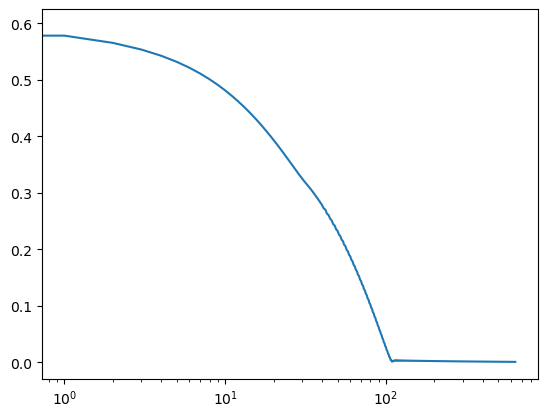

In [60]:
import matplotlib.pyplot as plt
plt.plot(error[1:])
plt.xscale('log')

In [61]:
for factor in Belief_prop_graph.graph._factors:
    print(factor.name,'\t', factor.potential)

h_0 	 1.999330316095366
h_1 	 1.4993302096658554
J_1,2 	 -2.0006825626741347


# Sampling

In [90]:
sample=np.zeros(2)
for i in range(100000):
    Belief_prop_graph.sample_from_tree()
    sample=np.vstack([sample, Belief_prop_graph.configuration])
sample=sample[1:]

In [99]:
m=np.mean(sample, axis=0)

In [104]:
Cor=sample.T@sample/len(sample)


p_i = [(1-m[0])/2,(1+m[0])/2]
p_j = [(1-m[1])/2,(1+m[1])/2]
print('p_i=',p_i,'p_j=', p_j)
p_ij = 0 ## --, -+, +-, ++
for s1 in [-1,1]:
    for s2 in [-1,1]:
        p_ij=(1/4*(Cor[0,1]*s1*s2+m[0]*s1+m[1]*s2+1))
        print(s1, s2, p_ij)

p_i= [0.28109, 0.7189099999999999] p_j= [0.45605, 0.54395]
-1 -1 0.008380000000000026
-1 1 0.27271
1 -1 0.44767
1 1 0.27124
